In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 4.3 MB/s 
     |████████████████████████████████| 235 kB 55.6 MB/s 
     |████████████████████████████████| 965 kB 46.8 MB/s 
     |████████████████████████████████| 581 kB 64.6 MB/s 


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import underthesea
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

##Download dữ liệu từ git


In [63]:
!git clone https://github.com/ItsHuyne/CS117_Final

Cloning into 'CS117_Final'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 11 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [64]:
%cd /content/CS117_Final


/content/CS117_Final


In [65]:
!git pull


Already up to date.


In [66]:
dataset=pd.read_csv("/content/CS117_Final/FinalData.csv")

In [67]:
dataset.info

<bound method DataFrame.info of        label                                               text
0          1  Thấm nhanh, thơm, còn lại thì phải chờ thời gi...
1          1  Mua tặng bx. Gọn nhẹ, màn oled đẹp, cam đỉnh. ...
2          1       Ốp đẹp lắmmmmmmmmmmmmmmmm ạ.................
3          1  Mình mua ốp trong suốt này của shop mấy lần rồ...
4         -1  Đóng gói sản phẩm rất tệ lọ bị chảy ra nhiều.H...
...      ...                                                ...
11499      1  Đẹp lắm mng oii săn đc flash sale còn rẻ nx mê...
11500      1  Ốp đẹp lắm luôn ạ. Đẹp từ vỏ hộp. Săn deal đượ...
11501      1  Đồ xinh lắm ak, giao hàng nhanh nhiệt tình sẽ ...
11502      1  Hihi có hơi mỏng so với tưởng tượng nhma với g...
11503      0  Hyhybbyixjnxbxghxoyknxbxjkxnxbxnkynxbbxb b. Nỵ...

[11504 rows x 2 columns]>

In [68]:
dataset['label'].value_counts()

 1    7897
 0    2150
-1    1457
Name: label, dtype: int64

In [69]:
X_data=dataset['text']
Y_data=dataset['label']

##Phân phối các lớp

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


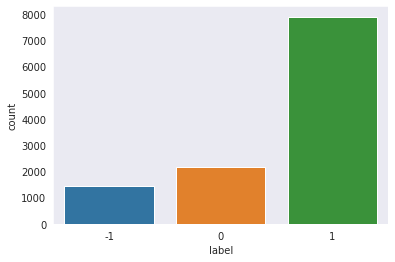

In [70]:
import seaborn as sns
sns.set_style("dark")
sns.countplot(dataset.label)

##Tiền xử lý dữ liệu


In [71]:
#Đưa về kiểu chữ thường
def text_lowercase(text):
    return text.lower()

In [72]:
#Loại bỏ các con số
def remove_number(text):
    result = re.sub(r'\d+', '', text) 
    return result

In [73]:
#Loại bỏ các dấu câu
def remove_punctuation(text):
    text = text.replace(",", " ").replace(".", " ") \
    .replace(";", " ").replace("“", " ") \
    .replace(":", " ").replace("”", " ") \
    .replace('"', " ").replace("'", " ") \
    .replace("!", " ").replace("?", " ") \
    .replace("-", " ").replace("?", " ")  
    return text

In [74]:
#Loại bỏ khoảng trắng thừa
def remove_whitespace(text): 
    return  " ".join(text.split())

In [75]:
# Bỏ bớt các chữ cái giống nhau liên tiếp( Vd: quaaa -> qua)
def remove_similarletter(text):
    text = re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)
    return text

In [76]:
#Tách từ tiếng Việt sử dụng thư viện underthesea có sẵn
def VN_Tokenize(text,format='text'):
  return underthesea.word_tokenize(text)

In [77]:
!gdown --id 1buHsfg9uC70tuUNe852UBCZxcqFg4re5
#tải stopword

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1buHsfg9uC70tuUNe852UBCZxcqFg4re5
To: /content/CS117_Final/vietnamese-stopwords-dash (1).txt
100% 14.8k/14.8k [00:00<00:00, 15.4MB/s]


In [78]:
#Loại bỏ các stopwords tiếng Việt sử dụng bộ stopwords có sẵn lấy từ
def remove_VN_stopwords(text):
    file_stopwords = pd.read_csv("vietnamese-stopwords-dash (1).txt", encoding = 'UTF-8')
    file_stopwords.columns = ["Stop_words"]

    VN_stopword = []
    for i in file_stopwords["Stop_words"]:
        VN_stopword.append(i)
        
    text_token = VN_Tokenize(text)
    result = [word for word in text_token if word not in VN_stopword]
    return " ".join(result)

In [79]:
#Chuẩn hóa dữ liệu
def Util(text):
    replace_list = {
        'ship': 'vận chuyển', 'shop': 'cửa hàng', 'sho': 'cửa hàng', 'm': 'mình','mk':'mình','mjk':'mình', 'mik': 'mình', 'ko': 'không' , 'k': 'không', 'kh': 'không', 'khong': 'không', 'kg': 'không', 'khg': 'không','hok':'không','hong':'không', 'tl': 'trả lời',
        'rep': 'trả lời', 'r': 'rồi', 'fb': 'facebook', 'face': 'faceook', 'thanks': 'cảm ơn', 'thank': 'cảm ơn', 'tks': 'cảm ơn', 'tk': 'cảm ơn', 'ok': 'tốt', 'oki': 'tốt', 'okie': 'tốt', 'sp': 'sản phẩm',
        'dc': 'được','đc':'được','dk':'được', 'vs': 'với', 'đt': 'điện thoại', 'thjk': 'thích', 'thik': 'thích', 'qá': 'quá', 'trể': 'trễ', 'bgjo': 'bao giờ', 'h': 'giờ', 'qa': 'quá', 'dep': 'đẹp', 'xau': 'xấu', 'ib': 'nhắn tin',
        'cute': 'dễ thương', 'sz': 'size', 'good': 'tốt', 'god': 'tốt', 'bt': 'bình thường','tr':'triệu','dag':'đang','nhiu':'nhiêu','mn':'mọi người','m.n':'mọi người','ac':'anh chị','sag':'sang','s':'sao',
        'sz': 'cỡ', 'size': 'cỡ', 'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được','ae':'anh em','j':'gì','hnay':'hôm nay','lm':'làm','ktra':'kiểm tra','sp':'sản phẩm','zô':'vào',
        'đc': 'được', 'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth ': 'chuẩn chính hãng', 'thick': 'thích','v':'vậy','cng':'cũng','cg':'cũng','ns':'nói','nv':'nhân viên',
        'gud': 'tốt', 'god': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt','ng':'người','chs':'chơi','mng':'mọi người','wa':'quá',
        'sấu': 'xấu', 'gut': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt','trc':'trước',
        'time': 'thời gian', 'qá': 'quá','nc':'nói chung','ace':'anh chị em',
        'product': 'sản phẩm', 'quality': 'chất lượng', 'chat': 'chất' , 'excelent': 'hoàn hảo', 'bad': 'tệ', 'sad': 'tệ',
        'beautiful': 'đẹp', 'tl': 'trả lời', 'r': 'rồi', 'order': 'đặt hàng',
        'chất lg': 'chất lượng', 'sd': 'sử dụng', 'dt': 'điện thoại', 'nt': 'nhắn tin', 'tl': 'trả lời', 'sài': 'xài', 'bjo': 'bao giờ',
        'thik': 'thích', 'sop': 'cửa hàng', 'fb': 'facebook', 'face': 'facebook', 'very': 'rất',
        'dep': 'đẹp', 'xau': 'xấu','tgdđ':'thế giới di động','tgdd':'thế giới di động','đmx':'điện máy xanh',
        'iu': 'yêu', 'fake': 'giả mạo', 'trl': 'trả lời', '><': 'tiêu cực',
        'por': 'tệ', 'poor': 'tệ', 'ib': 'nhắn tin', 'rep': 'trả lời', 'fback': 'feedback', 'fedback': 'feedback',
        'bin': 'pin', 'cx': 'cũng', 'nch': 'nói chuyện', 'ntn': 'như thế nào', 'vde': 'vấn đề'
    }
    text = text.split()
    len_ = len(text)
    for i in range(0, len_):    
      for k, v in replace_list.items():
        if (text[i]==k):
          text[i] = v
    return " ".join(text)

In [80]:
def Text_PreProcessing_noutil(data):
  result_1 = []
  for i in data:
    i = str(i)
    text = text_lowercase(i)
    text = Util(text)
    text = remove_similarletter(text)
    text = remove_number(text)
    text = remove_punctuation(text)
    text = remove_whitespace(text)
    text = remove_VN_stopwords(text)
    result_1.append(text)
  return result_1

In [81]:
X_data_1 = X_data
Y_data_1 = Y_data

In [82]:
X_data_1 = Text_PreProcessing_noutil(X_data_1)

## Feature Extraction

In [83]:
vectorizer_1 = TfidfVectorizer()
vectorizer_1.fit(X_data_1)
X_data_tfidf_1 = vectorizer_1.transform(X_data_1).toarray()

# Phân chia tập train và test


In [84]:
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_data_tfidf_1, Y_data_1, test_size=0.3)

In [86]:
print(X_train_1)
print(X_data_tfidf_1.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(11504, 6968)


# Huấn luyện mô hình và đánh giá kết quả

In [88]:
model_1 = SVC(kernel='linear')
model_1.fit(X_train_1, Y_train_1)
print("Model SVC")
print("Train score: ", model_1.score(X_train_1, Y_train_1))
print("Test score: ", model_1.score(X_test_1, Y_test_1))
y_pred_1 = model_1.predict(X_test_1)
print("F1 score: ",f1_score(Y_test_1, y_pred_1, average = 'macro'))

Model SVC
Train score:  0.9131892697466468
Test score:  0.8238702201622248
F1 score:  0.7324870997741093


In [98]:
#đoạn code thể hiện confusion matrix lấy từ : https://datascience.stackexchange.com/questions/40067/confusion-matrix-three-classes-python?fbclid=IwAR2gosLkbym_WUq8o9ZgHmOxzn9nZUUfrHN5cLQxWCvZKq9BDLR_qr_f9qA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [101]:
cnf_matrix = confusion_matrix(Y_test_1, y_pred_1,labels=['-1', '0', '1'])
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[0 0 0]
 [0 0 0]
 [0 0 0]]


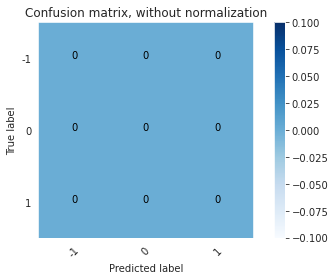

In [102]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[-1, 0, 1],
                      title='Confusion matrix, without normalization')

In [103]:
print(classification_report(Y_test_1, y_pred_1, target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.78      0.60      0.68       457
           0       0.66      0.58      0.62       663
           1       0.87      0.94      0.90      2332

    accuracy                           0.82      3452
   macro avg       0.77      0.71      0.73      3452
weighted avg       0.82      0.82      0.82      3452



In [104]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [105]:
modelnb = MultinomialNB()
modelnb.fit(X_train_1, Y_train_1)
print("Model MultinomialNB")
print("Train score: ", modelnb.score(X_train_1, Y_train_1))
print("Test score: ", modelnb.score(X_test_1, Y_test_1))
y_pred_nb = modelnb.predict(X_test_1)
print("F1 score: ",f1_score(Y_test_1, y_pred_nb, average = 'macro'))

Model MultinomialNB
Train score:  0.817933432687531
Test score:  0.7610081112398609
F1 score:  0.5799103601029336


Confusion matrix, without normalization
[[ 148   67  242]
 [  16  197  450]
 [   1   49 2282]]
              precision    recall  f1-score   support

          -1       0.90      0.32      0.48       457
           0       0.63      0.30      0.40       663
           1       0.77      0.98      0.86      2332

    accuracy                           0.76      3452
   macro avg       0.76      0.53      0.58      3452
weighted avg       0.76      0.76      0.72      3452



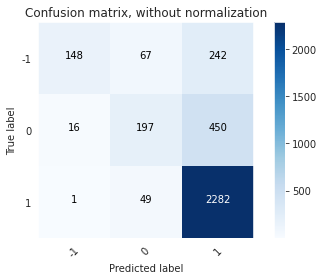

In [107]:
cnf_matrix_nb = confusion_matrix(Y_test_1, y_pred_nb, labels=[-1, 0, 1])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_nb, classes=[-1, 0, 1],
                      title='Confusion matrix, without normalization')
print(classification_report(Y_test_1, y_pred_nb, target_names=['-1', '0', '1']))

In [108]:
modellr = LogisticRegression()
modellr.fit(X_train_1, Y_train_1)
print("Model LogisticRegression")
print("Train score: ", modellr.score(X_train_1, Y_train_1))
print("Test score: ", modellr.score(X_test_1, Y_test_1))
y_pred_lr = modellr.predict(X_test_1)
print("F1 score: ",f1_score(Y_test_1, y_pred_lr, average = 'macro'))

Model LogisticRegression
Train score:  0.8964232488822653
Test score:  0.8224217844727694
F1 score:  0.7268038229450836


Confusion matrix, without normalization
[[ 254   85  118]
 [  40  392  231]
 [  23  116 2193]]


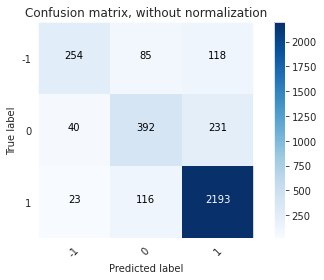

In [109]:
cnf_matrix_lr = confusion_matrix(Y_test_1, y_pred_lr, labels=[-1, 0, 1])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_lr, classes=[-1, 0, 1],
                      title='Confusion matrix, without normalization')

In [110]:
print(classification_report(Y_test_1, y_pred_lr, target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.80      0.56      0.66       457
           0       0.66      0.59      0.62       663
           1       0.86      0.94      0.90      2332

    accuracy                           0.82      3452
   macro avg       0.78      0.70      0.73      3452
weighted avg       0.82      0.82      0.81      3452



In [111]:
modelrdf = RandomForestClassifier(n_estimators=10)
modelrdf.fit(X_train_1, Y_train_1)
print("Model RandomForestClassifier")
print("Train score: ", modelrdf.score(X_train_1, Y_train_1))
print("Test score: ", modelrdf.score(X_test_1, Y_test_1))
y_pred_rdf = modelrdf.predict(X_test_1)
print("F1 score: ",f1_score(Y_test_1, y_pred_rdf, average = 'macro'))

Model RandomForestClassifier
Train score:  0.9855936413313463
Test score:  0.8146002317497103
F1 score:  0.7108838235481039


Confusion matrix, without normalization
[[ 254   71  132]
 [  71  378  214]
 [  42  110 2180]]


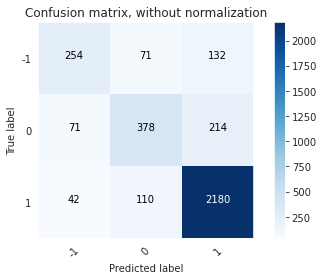

In [112]:
cnf_matrix_rdf = confusion_matrix(Y_test_1, y_pred_rdf, labels=[-1, 0, 1])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix_rdf, classes=[-1, 0, 1],
                      title='Confusion matrix, without normalization')

In [113]:
print(classification_report(Y_test_1, y_pred_rdf, target_names=['-1', '0', '1']))

              precision    recall  f1-score   support

          -1       0.69      0.56      0.62       457
           0       0.68      0.57      0.62       663
           1       0.86      0.93      0.90      2332

    accuracy                           0.81      3452
   macro avg       0.74      0.69      0.71      3452
weighted avg       0.80      0.81      0.81      3452



##Dự đoán 


In [114]:
import joblib
joblib.dump(vectorizer_1, 'tf_idf.pkl')
#joblib.dump(modellr, "bestmodel.pkl")

['tf_idf.pkl']

In [115]:
model_1

SVC(kernel='linear')

In [116]:
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
#!wget https://github.com/ThuanPhong0126/CS114.K21/blob/master/Project/tfidf_pyvi.pkl?raw=true
# !wget https://github.com/ThuanPhong0126/CS114.K21/blob/master/Project/model_SVC.sav?raw=true

#!pip install pyvi
import joblib
import pandas as pd
from pyvi import ViTokenizer

def Token(t):
  return ViTokenizer.tokenize(t)

def standardize_data(t):

  t = t.lower()
  t = t.replace(',', ' ').replace('.', ' ')\
      .replace(";", " ").replace("“", " ") \
      .replace(":", " ").replace("”", " ") \
      .replace('"', " ").replace("'", " ") \
      .replace("!", " ").replace("?", " ").replace("-", " ").replace("?", " ") 
  t = t.strip()
  return t

def du_doan(comment):
  emb_loaded=joblib.load('tf_idf.pkl')
  model_loaded=joblib.load('bestmodel.pkl')
  comment=comment.strip()
  print(comment)
  feature=pd.Series(comment.split('.'))
  comment=feature
  feature = feature.apply(standardize_data)
  feature=emb_loaded.transform(feature).toarray()
  #print(feature.shape)
  predict=model_loaded.predict(feature)
  
  if predict==1:
      return ("Bình luận tốt về sản phẩm")
  if predict==0:
      return ("Bình luận không liên quan hoặc trung tính về sản phẩm")
  if predict==-1:
      return ("Bình luận kém về sản phẩm")

In [118]:
!pip install gradio


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
import gradio as gr

In [120]:
# Define Gradio interface
gradio_ui = gr.Interface(
    fn=du_doan,
    title="Phân tích cảm xúc bình luận sản phẩm",
    description="Nhập câu bình luận về sản phâm",
    inputs=gr.inputs.Textbox(lines=1, label="Paste comment text here"),
    outputs=gr.outputs.Textbox(label="Chất lượng sản phẩm"),
)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [121]:
gradio_ui.launch()


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://40871.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f7ab1b30f50>,
 'http://127.0.0.1:7861/',
 'https://40871.gradio.app')